In [15]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.preprocessing import OneHotEncoder
from keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.layers import Dense,MaxPooling1D,Conv1D,Dropout,Flatten
from keras.models import Sequential

In [16]:
tess_path=r"/kaggle/input/speech-emotion-recognition-en/Tess"
labels=[]
paths=[]
for root,sub_directories,files in os.walk(tess_path):
    for filename in files:
        label=filename.split("_")[-1]
        label=label.split(".")[0]
        labels.append(label.lower())
        path=os.path.join(root,filename)
        paths.append(path)

In [17]:
df=pd.DataFrame({"path":paths,"label":labels})

<Axes: xlabel='label', ylabel='count'>

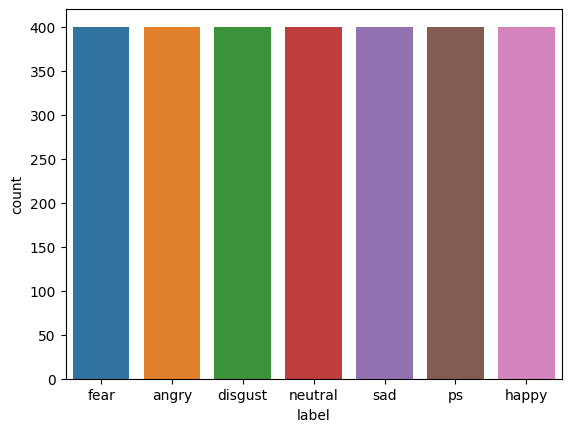

In [18]:
sns.countplot(data=df,x="label")

In [19]:
def create_wavelet(data,sr,e):
    plt.figure(figsize=(15,6))
    plt.title("Wavelet of {} audio".format(e))
    librosa.display.waveshow(data,sr=sr)
    plt.show()
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

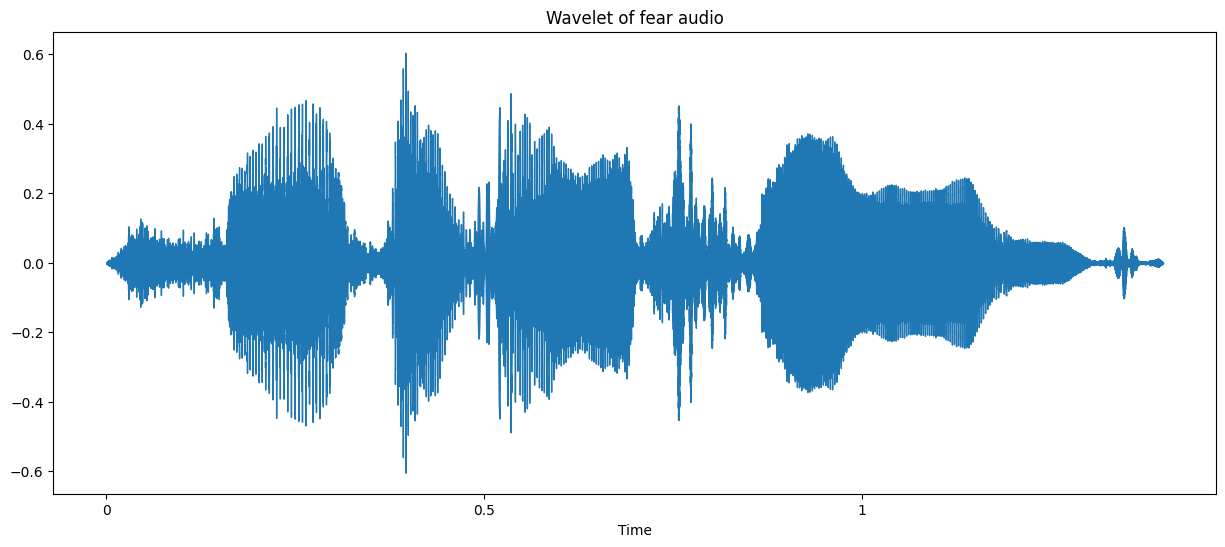

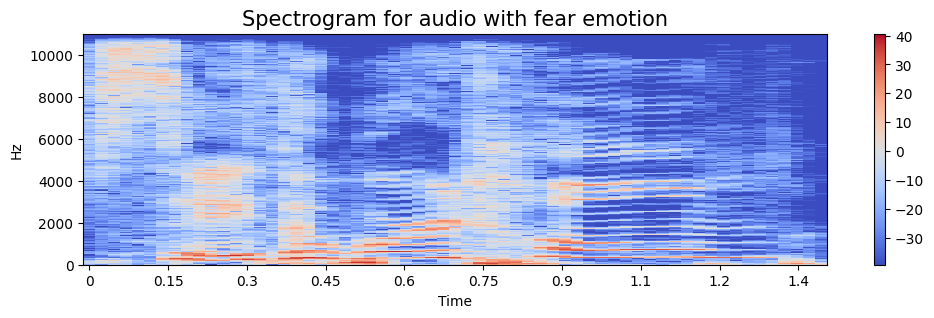

In [20]:
emotion="fear"
fear_path=np.array(df.path[df.label==emotion])[0]
audio_data,sr=librosa.load(fear_path)
create_wavelet(audio_data,sr,emotion)
create_spectrogram(audio_data, sr, emotion)
Audio(fear_path)

In [21]:
def extract_features(data, sample_rate):
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=13).T, axis=0)

    # Pitch
    pitch = librosa.yin(data, fmin=75, fmax=600, sr=sample_rate)

    # Energy
    energy = np.mean(librosa.feature.rms(y=data).T, axis=0)

    # Formants (could be estimated using LPC analysis)
    # Zero Crossing Rate
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)

    # Additional Spectral Features
    # You can add more spectral features such as spectral centroid, bandwidth, etc.

    # Concatenate all features into one feature vector
    result = np.hstack((mfcc, pitch, energy, zero_crossing_rate))

    return result


def get_features(path, max_length):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # Extract features
    feature = extract_features(data, sample_rate)

    # Pad or truncate feature vector to max_length
    if len(feature) < max_length:
        # Pad feature vector with zeros
        feature = np.pad(feature, (0, max_length - len(feature)))
    elif len(feature) > max_length:
        # Truncate feature vector
        feature = feature[:max_length]

    return feature


In [22]:
max_length = 100  # Specify the maximum length for feature vectors
X, Y = [], []
for path, emotion in zip(df['path'], df['label']):
    feature = get_features(path, max_length)
    X.append(feature)
    Y.append(emotion)


In [23]:
Features=pd.DataFrame(X)

In [24]:
Features["labels"]=Y

In [25]:
Features

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,labels
0,-289.884491,78.489967,-4.182045,23.008759,-16.212927,9.779065,10.071579,-6.281808,-0.073307,11.285912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
1,-354.465851,34.171494,-4.104850,15.732569,6.037578,-2.317045,-4.334206,-7.286572,-20.251268,1.631115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
2,-345.312927,52.623024,-14.716514,21.746553,10.839085,-4.617684,-3.773532,-11.022669,-3.550835,4.633787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
3,-311.238159,19.589220,-3.332211,5.829777,-7.838949,9.776418,-0.377178,-13.403923,-8.565652,15.941558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
4,-350.903198,45.258297,-25.615816,20.646034,2.475903,-8.119964,-4.508938,5.885363,-2.373116,3.978343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,fear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-380.947113,59.848995,1.015735,11.924616,-22.682590,-7.787716,-7.180370,-15.592613,-10.214118,-1.954412,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ps
2796,-312.378815,40.789986,-3.059981,-3.569185,-51.935749,10.801569,2.223383,-19.000631,-4.400588,-3.842497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ps
2797,-358.984344,81.974594,-14.004902,3.585549,-21.469200,3.242538,-3.282119,-25.536808,-4.407302,-1.992004,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ps
2798,-361.591431,104.695442,-13.589814,-10.557706,-29.525148,-2.383105,-3.539778,-20.092840,-16.460690,-7.388576,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ps


In [26]:
ohe_encoder=OneHotEncoder()
Y=ohe_encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [27]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2)

In [28]:
scaler=StandardScaler()

x_train=scaler.fit_transform(x_train)
x_test=scaler.transform(x_test)

In [29]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))

model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 50, 256)        │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 25, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 13, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 549,063 (2.09 MB)

 Trainable params: 549,063 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.2963 - loss: 1.7244 - val_accuracy: 0.5000 - val_loss: 1.1967
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5312 - loss: 1.1735 - val_accuracy: 0.7875 - val_loss: 0.5708
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.7152 - loss: 0.7656 - val_accuracy: 0.9286 - val_loss: 0.3090
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 0.8248 - loss: 0.4994 - val_accuracy: 0.9554 - val_loss: 0.1599
Epoch 5/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.8849 - loss: 0.3156 - val_accuracy: 0.9304 - val_loss: 0.1988
Epoch 6/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.8866 - loss: 0.3181 - val_accuracy: 0.9607 - val_loss: 0.1263
Epoch 7/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9181 - loss: 0.2496 - val_accuracy: 0.9589 - val_loss: 0.0868
Epoch 8/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9545 - loss: 0.1572 - val_accuracy: 0.

In [31]:
from sklearn.metrics import classification_report

# Reshape x_test for Conv1D input shape
x_test_reshaped = np.expand_dims(x_test, axis=2)

# Predictions
predictions = model.predict(x_test_reshaped)

# Convert predictions to labels
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded y_test back to labels
true_labels = np.argmax(y_test, axis=1)

# Generate classification report
print(classification_report(true_labels, predicted_labels))


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        86
           1       0.91      0.95      0.93        65
           2       0.97      1.00      0.98        83
           3       0.99      0.96      0.97        92
           4       0.99      0.97      0.98        80
           5       0.94      0.90      0.92        83
           6       0.99      1.00      0.99        71

    accuracy                           0.96       560
   macro avg       0.96      0.96      0.96       560
weighted avg       0.96      0.96      0.96       560

